In [299]:
import glob
import os.path
import numpy as np
from PIL import Image
import matplotlib.lines as mline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

Using TensorFlow backend.


In [300]:
def model_constructor_convex(lr):
    model = keras.Sequential([
            keras.Input(shape=Xtrain.shape[1:]),
            layers.Dense(units=1)
        ])
    sgd_optimizer = keras.optimizers.SGD(learning_rate=lr)
    model.compile(loss="mean_squared_error", optimizer=sgd_optimizer, metrics=["accuracy"])
    print(model.summary())
    return model
def custom_activation(x):
    return K.sin(x)
def model_constructor_non_convex(lr):
    model = keras.Sequential([
            keras.Input(shape=Xtrain.shape[1:]),
            layers.Dense(units=1,activation = custom_activation)
        ])
    sgd_optimizer = keras.optimizers.SGD(learning_rate=lr)
    model.compile(loss="mean_squared_error", optimizer=sgd_optimizer, metrics=["accuracy"])
    print(model.summary())
    return model
def split_training_data(X_train, y_train, num_splits, iid, rng):
    if iid:
        train_order = rng.permutation(X_train.shape[0])
    else:
        train_order = np.argsort(y_train)
        
    X_train = X_train[train_order]
    y_train = y_train[train_order]
    X_train_splits = np.array_split(X_train, num_splits)
    y_train_splits = np.array_split(y_train, num_splits)

    split_weights = [X_train_splits[i].shape[0] / X_train.shape[0] for i in range(num_splits)]  
    
    return X_train_splits, y_train_splits, split_weights

In [292]:
############################################################################
# FEDERATED AVERAGING (McMahan, Brendan, et al. 2017)
############################################################################

def federated_averaging(model_constructor,start_point, X_train, y_train, X_val, y_val, K, C, E, B, MAX_T, iid, rng):
    """
    Trains a global model by running up to MAX_T rounds of FederatedAveraging over K workers.
    Returns the final global model and train/val metrics per communciation round.
    
    Parameters
    ----------
    X_train : numpy ndarray
        Training features of shape (n, d) for d-dimensional features
    y_train : numpy ndarray
        Training targets of shape (n, k) for k-dimensional targets
    X_val : numpy ndarray
        Validation features of shape (n, d) for d-dimensional features
    y_val : numpy ndarray
        Validation targets of shape (n, k) for k-dimensional targets
        
    The following variables are named to match the paper:
    
    K : int
        The number of workers
    C : float
        The fraction of workers randomly selected per round
    E : int
        The number of epochs a worker will run over its data per round
    B : int
        The worker minibatch size
    
    The following variables are not assigned explicit names in the paper:
    
    MAX_T : int
        Maximum number of rounds of FederatedAveraging to run
    iid : bool
        If iid, we simulate an evenly distributed random split of the data across
        workers. Otherwise each worker gets data in only one (or few) classes
    rng : numpy random._generator.Generator
        The random generator to use
    Returns
    -------
    global_model : Keras Model
        The final output model after FederatedAveraging is complete
    communication_rounds : dict
        Dictionary containing per-communiction-round metrics
    """
    
    #Partition the dataset into K splits
    
    #Note: In the real world we would not have access to the dataset as it would be distributed
    #      across all the worker devices. Here in simulation, we have access to the complete dataset
    #      and define the splits that go to each worker.
    
    #split_weights is the weight for each split (n_k / n) used for the weighted averaging
    #of worker weights at the end of each round of FederatedAveraging
    X_train_splits, y_train_splits, split_weights = split_training_data(X_train, y_train, K, iid, rng)    
    
    workers = []
    #Create K worker models
    for i in range(K):
        workers.append(model_constructor)

    #Create the global model
    global_model = model_constructor
    global_model.set_weights(start_point)
    global_weights = global_model.get_weights()
    
    #Execute the rounds of FederatedAveraging
    communication_rounds = {"loss": [], "global_weights":[]}
    communication_rounds["global_weights"].append(global_weights.copy())
    m = int(np.ceil(C*K)) # Number of workers to use per round
    #Note: In the real world each worker would perform its update in parallel on a separate device.
    #      Here in simulation, we can perform worker updates sequentially on the same device.
    for t in range(MAX_T):
        #Randomly pick the workers to be used for this round
        worker_indices = rng.integers(K, size=m)
        
        #Perform the local update on each randomly selected worker starting from the global weights
        worker_weights = [global_weights for i in range(len(workers))]
        for wk_i in worker_indices:
            worker = workers[wk_i]
            worker.set_weights(global_weights)
            #print(X_train_splits[wk_i])
            worker.fit(X_train_splits[wk_i], y_train_splits[wk_i], batch_size=B, epochs=E)
            #Return the worker weights to the "server"
            worker_weights[wk_i] = worker.get_weights()
        print("global_weights before update:",global_weights)
        print("worker_weights:",worker_weights)
        
        #Average all the worker weights to get the updated global weights
        for i in range(len(global_weights)):
            global_weights[i] = np.sum([split_weights[i]*w[i] for w in worker_weights], axis=0)
        print("global_weights after updates:",global_weights)
        gw = global_weights.copy()
        #Evaluate the global model on the test set
        global_model.set_weights(global_weights)
        communication_rounds["global_weights"].append(gw)
        score = global_model.evaluate(X_train, y_train)
        communication_rounds["loss"].append(score[0])  
 
    return global_model, communication_rounds

In [247]:
def Loss1(x,y,w1,w2):
    return (y- (x*w1+w2))**2

def Loss2(x,y,w1,w2):
    a = np.sin(w1*x+w2)
    return (y-a)**2
def TotalLoss1(X,Y,w1,w2):
    n = len(X)
    total = 0
    for i in range(n):
        y = Y[i]
        x = X[i]
        total = total + Loss1(x,y,w1,w2)
    return total/n
def TotalLoss2(X,Y,w1,w2):
    n = len(X)
    total = 0
    for i in range(n):
        y = Y[i]
        x = X[i]
        total = total + Loss2(x,y,w1,w2)
    return total/n
def gradwloss(x,y,w1,w2):
    return 2*(w1*x+w2-y)*x
def gradbloss(x,y,w1,w2):
    return 2*(w1*x+w2-y)


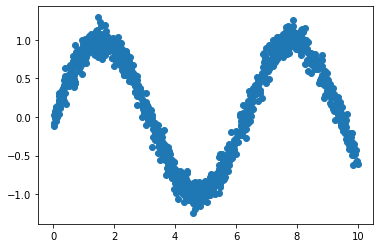

In [196]:
############################################################################
# SETUP
############################################################################
rng = np.random.default_rng(seed=100)
n_train = 1000
sigma = 0.1
Xtrain = np.random.uniform(size= n_train)*10
Xtrain = Xtrain.reshape(n_train,1)
Ytrain = np.zeros(n_train)
for i in range(n_train):
    Ytrain[i] = np.random.normal(np.sin(Xtrain[i]), sigma, 1)
plt.scatter(Xtrain, Ytrain)


In [234]:
experiment = {"K": 2, "C": 1, "E": 1, "B": int(len(Xtrain)/10), "MAX_T": 100, "iid": True}
global_model, communication_rounds = federated_averaging(model_constructor_convex(0.002),[np.array([[4]], dtype=np.float32), np.array([3], dtype=np.float32)], Xtrain, Ytrain, Xtrain, Ytrain,rng = rng,**experiment)

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None
500/500 [==============================] - 0s 14us/sample - loss: 386.2545 - acc: 0.0000e+00
global_weights before update: [array([[4.]], dtype=float32), array([3.], dtype=float32)]
worker_weights: [[array([[1.8473227]], dtype=float32), array([2.656779], dtype=float32)], [array([[4.]], dtype=float32), array([3.], dtype=float32)]]
global_weights after updates: [array([[2.9236612]], dtype=float32), array([2.8283896], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss: 219.7673 - acc: 0.0000e+00
global_weights before update: [array([[2.9236612]], dtype=float32), array([2.8283896], dtype=float32)]
worker_weights: [

500/500 [==============================] - 0s 12us/sample - loss: 1.3790 - acc: 0.0000e+00
global_weights before update: [array([[-0.31221014]], dtype=float32), array([2.1671023], dtype=float32)]
worker_weights: [[array([[-0.31394568]], dtype=float32), array([2.1570823], dtype=float32)], [array([[-0.31221014]], dtype=float32), array([2.1671023], dtype=float32)]]
global_weights after updates: [array([[-0.31307793]], dtype=float32), array([2.1620922], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss: 1.3766 - acc: 0.0000e+00
global_weights before update: [array([[-0.31307793]], dtype=float32), array([2.1620922], dtype=float32)]
worker_weights: [[array([[-0.3116425]], dtype=float32), array([2.1525788], dtype=float32)], [array([[-0.3069069]], dtype=float32), array([2.1532683], dtype=float32)]]
global_weights after updates: [array([[-0.3092747]], dtype=float32), array([2.1529236], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - los

500/500 [==============================] - 0s 12us/sample - loss: 1.2993 - acc: 0.0000e+00
global_weights before update: [array([[-0.29755837]], dtype=float32), array([2.083208], dtype=float32)]
worker_weights: [[array([[-0.29880062]], dtype=float32), array([2.0737135], dtype=float32)], [array([[-0.29755837]], dtype=float32), array([2.083208], dtype=float32)]]
global_weights after updates: [array([[-0.2981795]], dtype=float32), array([2.0784607], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss: 1.2656 - acc: 0.0000e+00
global_weights before update: [array([[-0.2981795]], dtype=float32), array([2.0784607], dtype=float32)]
worker_weights: [[array([[-0.29915136]], dtype=float32), array([2.069029], dtype=float32)], [array([[-0.29436406]], dtype=float32), array([2.069726], dtype=float32)]]
global_weights after updates: [array([[-0.2967577]], dtype=float32), array([2.0693774], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss: 1

500/500 [==============================] - 0s 12us/sample - loss: 1.2158 - acc: 0.0000e+00
global_weights before update: [array([[-0.28363276]], dtype=float32), array([1.989828], dtype=float32)]
worker_weights: [[array([[-0.2850118]], dtype=float32), array([1.9808085], dtype=float32)], [array([[-0.27878997]], dtype=float32), array([1.9817172], dtype=float32)]]
global_weights after updates: [array([[-0.28190088]], dtype=float32), array([1.9812629], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss: 1.2072 - acc: 0.0000e+00
global_weights before update: [array([[-0.28190088]], dtype=float32), array([1.9812629], dtype=float32)]
worker_weights: [[array([[-0.2832466]], dtype=float32), array([1.9722916], dtype=float32)], [array([[-0.28190088]], dtype=float32), array([1.9812629], dtype=float32)]]
global_weights after updates: [array([[-0.28257376]], dtype=float32), array([1.9767773], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - los

500/500 [==============================] - 0s 14us/sample - loss: 1.1197 - acc: 0.0000e+00
global_weights before update: [array([[-0.27326208]], dtype=float32), array([1.9135984], dtype=float32)]
worker_weights: [[array([[-0.27451023]], dtype=float32), array([1.9049976], dtype=float32)], [array([[-0.2698665]], dtype=float32), array([1.905657], dtype=float32)]]
global_weights after updates: [array([[-0.27218837]], dtype=float32), array([1.9053273], dtype=float32)]
500/500 [==============================] - 0s 14us/sample - loss: 1.1133 - acc: 0.0000e+00
global_weights before update: [array([[-0.27218837]], dtype=float32), array([1.9053273], dtype=float32)]
worker_weights: [[array([[-0.27296075]], dtype=float32), array([1.896846], dtype=float32)], [array([[-0.26582134]], dtype=float32), array([1.8978909], dtype=float32)]]
global_weights after updates: [array([[-0.26939106]], dtype=float32), array([1.8973684], dtype=float32)]
500/500 [==============================] - 0s 14us/sample - los

500/500 [==============================] - 0s 12us/sample - loss: 1.0535 - acc: 0.0000e+00
global_weights before update: [array([[-0.26027292]], dtype=float32), array([1.8331594], dtype=float32)]
worker_weights: [[array([[-0.26027292]], dtype=float32), array([1.8331594], dtype=float32)], [array([[-0.2562618]], dtype=float32), array([1.8257366], dtype=float32)]]
global_weights after updates: [array([[-0.25826734]], dtype=float32), array([1.829448], dtype=float32)]
500/500 [==============================] - 0s 10us/sample - loss: 1.0499 - acc: 0.0000e+00
global_weights before update: [array([[-0.25826734]], dtype=float32), array([1.829448], dtype=float32)]
worker_weights: [[array([[-0.26168644]], dtype=float32), array([1.820965], dtype=float32)], [array([[-0.25449798]], dtype=float32), array([1.8220092], dtype=float32)]]
global_weights after updates: [array([[-0.25809222]], dtype=float32), array([1.8214872], dtype=float32)]
500/500 [==============================] - 0s 10us/sample - loss

500/500 [==============================] - 0s 12us/sample - loss: 1.0255 - acc: 0.0000e+00
global_weights before update: [array([[-0.24613917]], dtype=float32), array([1.7571002], dtype=float32)]
worker_weights: [[array([[-0.2501319]], dtype=float32), array([1.7489134], dtype=float32)], [array([[-0.24613917]], dtype=float32), array([1.7571002], dtype=float32)]]
global_weights after updates: [array([[-0.24813554]], dtype=float32), array([1.7530068], dtype=float32)]
500/500 [==============================] - 0s 10us/sample - loss: 1.0210 - acc: 0.0000e+00
global_weights before update: [array([[-0.24813554]], dtype=float32), array([1.7530068], dtype=float32)]
worker_weights: [[array([[-0.25009573]], dtype=float32), array([1.7451549], dtype=float32)], [array([[-0.24499811]], dtype=float32), array([1.7458663], dtype=float32)]]
global_weights after updates: [array([[-0.24754691]], dtype=float32), array([1.7455106], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - l

In [235]:
global_weights = np.array(communication_rounds['global_weights'])

In [225]:
w = np.arange(-5,5, 0.25)
b = np.arange(-10, 10, 0.25)
W,B = np.meshgrid(w, b)
Ls = np.array([TotalLoss1(Xtrain,Ytrain,w,b) for w,b in zip(np.ravel(W), np.ravel(B))])
print(np.min(Ls))
L = Ls.reshape(W.shape)

0.46987087401142164


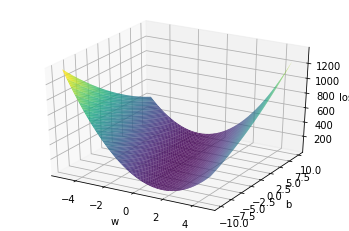

In [226]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W, B, L,rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('loss')

plt.show()

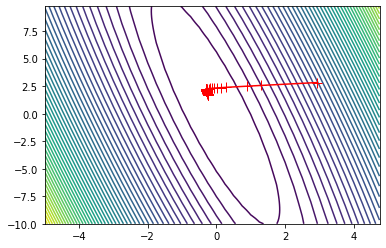

In [237]:
fig, ax = plt.subplots()
ax.contour(W,B,L,50)
transform = ax.transAxes
federated_avg = mline.Line2D(global_weights[:,0], global_weights[:,1], color='red', marker='+', markersize=10)
ax.add_line(federated_avg)
plt.show()

In [308]:
#Non convex test
experiment = {"K": 2, "C": 1, "E": 1, "B": int(len(Xtrain)/10), "MAX_T": 100, "iid": True}
global_model, communication_rounds = federated_averaging(model_constructor_non_convex(0.001),[np.array([[1.1]], dtype=np.float32), np.array([0.25], dtype=np.float32)], Xtrain, Ytrain, Xtrain, Ytrain,rng = rng,**experiment)
global_weights = np.array(communication_rounds['global_weights'])
global_model1, communication_rounds1 = federated_averaging(model_constructor_non_convex(0.001),[np.array([[0.85]], dtype=np.float32), np.array([-0.3], dtype=np.float32)], Xtrain, Ytrain, Xtrain, Ytrain,rng = rng,**experiment)
global_weights1 = np.array(communication_rounds1['global_weights'])

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None
500/500 [==============================] - 0s 12us/sample - loss: 0.2824 - acc: 0.0000e+00
global_weights before update: [array([[1.1]], dtype=float32), array([0.25], dtype=float32)]
worker_weights: [[array([[1.0818733]], dtype=float32), array([0.24690798], dtype=float32)], [array([[1.0825473]], dtype=float32), array([0.24704643], dtype=float32)]]
global_weights after updates: [array([[1.0822103]], dtype=float32), array([0.24697721], dtype=float32)]
500/500 [==============================] - 0s 16us/sample - loss: 0.2203 - acc: 0.0000e+00
global_weights before update: [array([[1.0822103]], dtype=float32), array([0.24697721], dtype=float32)]

500/500 [==============================] - 0s 14us/sample - loss: 0.0345 - acc: 0.0000e+00
global_weights before update: [array([[0.9991301]], dtype=float32), array([0.23253581], dtype=float32)]
worker_weights: [[array([[0.9939223]], dtype=float32), array([0.23147367], dtype=float32)], [array([[0.993342]], dtype=float32), array([0.23142958], dtype=float32)]]
global_weights after updates: [array([[0.99363214]], dtype=float32), array([0.23145163], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss: 0.0295 - acc: 0.0000e+00
global_weights before update: [array([[0.99363214]], dtype=float32), array([0.23145163], dtype=float32)]
worker_weights: [[array([[0.9893446]], dtype=float32), array([0.23052222], dtype=float32)], [array([[0.98878306]], dtype=float32), array([0.23048012], dtype=float32)]]
global_weights after updates: [array([[0.98906386]], dtype=float32), array([0.23050117], dtype=float32)]
500/500 [==============================] - 0s 14us/sample - loss:

500/500 [==============================] - 0s 16us/sample - loss: 0.0187 - acc: 0.0000e+00
global_weights before update: [array([[0.97251666]], dtype=float32), array([0.22593634], dtype=float32)]
worker_weights: [[array([[0.9717317]], dtype=float32), array([0.22552048], dtype=float32)], [array([[0.97251666]], dtype=float32), array([0.22593634], dtype=float32)]]
global_weights after updates: [array([[0.9721242]], dtype=float32), array([0.22572841], dtype=float32)]
500/500 [==============================] - 0s 14us/sample - loss: 0.0171 - acc: 0.0000e+00
global_weights before update: [array([[0.9721242]], dtype=float32), array([0.22572841], dtype=float32)]
worker_weights: [[array([[0.9721242]], dtype=float32), array([0.22572841], dtype=float32)], [array([[0.9710623]], dtype=float32), array([0.22530301], dtype=float32)]]
global_weights after updates: [array([[0.97159326]], dtype=float32), array([0.22551571], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss:

500/500 [==============================] - 0s 12us/sample - loss: 0.0164 - acc: 0.0000e+00
global_weights before update: [array([[0.9680426]], dtype=float32), array([0.22242147], dtype=float32)]
worker_weights: [[array([[0.9680289]], dtype=float32), array([0.22212194], dtype=float32)], [array([[0.96777767]], dtype=float32), array([0.22211368], dtype=float32)]]
global_weights after updates: [array([[0.96790326]], dtype=float32), array([0.22211781], dtype=float32)]
500/500 [==============================] - 0s 16us/sample - loss: 0.0181 - acc: 0.0000e+00
global_weights before update: [array([[0.96790326]], dtype=float32), array([0.22211781], dtype=float32)]
worker_weights: [[array([[0.9679162]], dtype=float32), array([0.22182252], dtype=float32)], [array([[0.96790326]], dtype=float32), array([0.22211781], dtype=float32)]]
global_weights after updates: [array([[0.9679097]], dtype=float32), array([0.22197017], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss

500/500 [==============================] - 0s 14us/sample - loss: 0.0180 - acc: 0.0000e+00
global_weights before update: [array([[0.9675422]], dtype=float32), array([0.21995711], dtype=float32)]
worker_weights: [[array([[0.9676525]], dtype=float32), array([0.21967848], dtype=float32)], [array([[0.9675422]], dtype=float32), array([0.21995711], dtype=float32)]]
global_weights after updates: [array([[0.96759737]], dtype=float32), array([0.21981779], dtype=float32)]
500/500 [==============================] - 0s 14us/sample - loss: 0.0162 - acc: 0.0000e+00
global_weights before update: [array([[0.96759737]], dtype=float32), array([0.21981779], dtype=float32)]
worker_weights: [[array([[0.96759737]], dtype=float32), array([0.21981779], dtype=float32)], [array([[0.96748513]], dtype=float32), array([0.21953468], dtype=float32)]]
global_weights after updates: [array([[0.9675412]], dtype=float32), array([0.21967623], dtype=float32)]
500/500 [==============================] - 0s 14us/sample - loss

500/500 [==============================] - 0s 14us/sample - loss: 0.0179 - acc: 0.0000e+00
global_weights before update: [array([[0.96774405]], dtype=float32), array([0.21760347], dtype=float32)]
worker_weights: [[array([[0.9678858]], dtype=float32), array([0.21733227], dtype=float32)], [array([[0.9676408]], dtype=float32), array([0.21732412], dtype=float32)]]
global_weights after updates: [array([[0.9677633]], dtype=float32), array([0.21732819], dtype=float32)]
500/500 [==============================] - 0s 14us/sample - loss: 0.0161 - acc: 0.0000e+00
global_weights before update: [array([[0.9677633]], dtype=float32), array([0.21732819], dtype=float32)]
worker_weights: [[array([[0.9677633]], dtype=float32), array([0.21732819], dtype=float32)], [array([[0.9676685]], dtype=float32), array([0.21705031], dtype=float32)]]
global_weights after updates: [array([[0.96771586]], dtype=float32), array([0.21718925], dtype=float32)]
500/500 [==============================] - 0s 14us/sample - loss: 

500/500 [==============================] - 0s 14us/sample - loss: 0.0178 - acc: 0.0000e+00
global_weights before update: [array([[0.96812963]], dtype=float32), array([0.2155614], dtype=float32)]
worker_weights: [[array([[0.9682633]], dtype=float32), array([0.21529147], dtype=float32)], [array([[0.9680148]], dtype=float32), array([0.21528257], dtype=float32)]]
global_weights after updates: [array([[0.96813905]], dtype=float32), array([0.21528703], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss: 0.0160 - acc: 0.0000e+00
global_weights before update: [array([[0.96813905]], dtype=float32), array([0.21528703], dtype=float32)]
worker_weights: [[array([[0.96813905]], dtype=float32), array([0.21528703], dtype=float32)], [array([[0.9680466]], dtype=float32), array([0.21501178], dtype=float32)]]
global_weights after updates: [array([[0.9680928]], dtype=float32), array([0.2151494], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss: 

500/500 [==============================] - 0s 14us/sample - loss: 0.0159 - acc: 0.0000e+00
global_weights before update: [array([[0.96819675]], dtype=float32), array([0.2132577], dtype=float32)]
worker_weights: [[array([[0.96819675]], dtype=float32), array([0.2132577], dtype=float32)], [array([[0.9681291]], dtype=float32), array([0.21298824], dtype=float32)]]
global_weights after updates: [array([[0.9681629]], dtype=float32), array([0.21312296], dtype=float32)]
500/500 [==============================] - 0s 16us/sample - loss: 0.0176 - acc: 0.0000e+00
global_weights before update: [array([[0.9681629]], dtype=float32), array([0.21312296], dtype=float32)]
worker_weights: [[array([[0.96833396]], dtype=float32), array([0.21286137], dtype=float32)], [array([[0.968128]], dtype=float32), array([0.21285826], dtype=float32)]]
global_weights after updates: [array([[0.96823096]], dtype=float32), array([0.21285981], dtype=float32)]
500/500 [==============================] - 0s 14us/sample - loss: 0

500/500 [==============================] - 0s 16us/sample - loss: 0.3768 - acc: 0.0000e+00
global_weights before update: [array([[0.8767643]], dtype=float32), array([-0.29477966], dtype=float32)]
worker_weights: [[array([[0.89493847]], dtype=float32), array([-0.2913048], dtype=float32)], [array([[0.8932706]], dtype=float32), array([-0.29171667], dtype=float32)]]
global_weights after updates: [array([[0.89410454]], dtype=float32), array([-0.29151073], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss: 0.3133 - acc: 0.0000e+00
global_weights before update: [array([[0.89410454]], dtype=float32), array([-0.29151073], dtype=float32)]
worker_weights: [[array([[0.9116291]], dtype=float32), array([-0.28822312], dtype=float32)], [array([[0.89410454]], dtype=float32), array([-0.29151073], dtype=float32)]]
global_weights after updates: [array([[0.90286684]], dtype=float32), array([-0.28986692], dtype=float32)]
500/500 [==============================] - 0s 14us/sampl

500/500 [==============================] - 0s 14us/sample - loss: 0.0359 - acc: 0.0000e+00
global_weights before update: [array([[1.0060599]], dtype=float32), array([-0.2707488], dtype=float32)]
worker_weights: [[array([[1.0113657]], dtype=float32), array([-0.26958817], dtype=float32)], [array([[1.0113304]], dtype=float32), array([-0.2696148], dtype=float32)]]
global_weights after updates: [array([[1.011348]], dtype=float32), array([-0.26960146], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss: 0.0320 - acc: 0.0000e+00
global_weights before update: [array([[1.011348]], dtype=float32), array([-0.26960146], dtype=float32)]
worker_weights: [[array([[1.0158054]], dtype=float32), array([-0.26857054], dtype=float32)], [array([[1.0157076]], dtype=float32), array([-0.26859593], dtype=float32)]]
global_weights after updates: [array([[1.0157565]], dtype=float32), array([-0.26858324], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss

500/500 [==============================] - 0s 12us/sample - loss: 0.0203 - acc: 0.0000e+00
global_weights before update: [array([[1.0322697]], dtype=float32), array([-0.26320654], dtype=float32)]
worker_weights: [[array([[1.0332909]], dtype=float32), array([-0.2627034], dtype=float32)], [array([[1.0329052]], dtype=float32), array([-0.26273263], dtype=float32)]]
global_weights after updates: [array([[1.033098]], dtype=float32), array([-0.26271802], dtype=float32)]
500/500 [==============================] - 0s 14us/sample - loss: 0.0201 - acc: 0.0000e+00
global_weights before update: [array([[1.033098]], dtype=float32), array([-0.26271802], dtype=float32)]
worker_weights: [[array([[1.0339731]], dtype=float32), array([-0.2622373], dtype=float32)], [array([[1.0335764]], dtype=float32), array([-0.26226696], dtype=float32)]]
global_weights after updates: [array([[1.0337747]], dtype=float32), array([-0.26225215], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss

500/500 [==============================] - 0s 12us/sample - loss: 0.0197 - acc: 0.0000e+00
global_weights before update: [array([[1.0359577]], dtype=float32), array([-0.25900075], dtype=float32)]
worker_weights: [[array([[1.0359577]], dtype=float32), array([-0.25900075], dtype=float32)], [array([[1.0358664]], dtype=float32), array([-0.25863507], dtype=float32)]]
global_weights after updates: [array([[1.035912]], dtype=float32), array([-0.2588179], dtype=float32)]
500/500 [==============================] - 0s 14us/sample - loss: 0.0194 - acc: 0.0000e+00
global_weights before update: [array([[1.035912]], dtype=float32), array([-0.2588179], dtype=float32)]
worker_weights: [[array([[1.0362548]], dtype=float32), array([-0.25842306], dtype=float32)], [array([[1.0358146]], dtype=float32), array([-0.25845346], dtype=float32)]]
global_weights after updates: [array([[1.0360347]], dtype=float32), array([-0.25843826], dtype=float32)]
500/500 [==============================] - 0s 14us/sample - loss

500/500 [==============================] - 0s 12us/sample - loss: 0.0195 - acc: 0.0000e+00
global_weights before update: [array([[1.0363711]], dtype=float32), array([-0.25551462], dtype=float32)]
worker_weights: [[array([[1.0363711]], dtype=float32), array([-0.25551462], dtype=float32)], [array([[1.0361323]], dtype=float32), array([-0.25517505], dtype=float32)]]
global_weights after updates: [array([[1.0362518]], dtype=float32), array([-0.25534484], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss: 0.0192 - acc: 0.0000e+00
global_weights before update: [array([[1.0362518]], dtype=float32), array([-0.25534484], dtype=float32)]
worker_weights: [[array([[1.0364541]], dtype=float32), array([-0.25497591], dtype=float32)], [array([[1.0362518]], dtype=float32), array([-0.25534484], dtype=float32)]]
global_weights after updates: [array([[1.0363529]], dtype=float32), array([-0.2551604], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - l

500/500 [==============================] - 0s 16us/sample - loss: 0.0193 - acc: 0.0000e+00
global_weights before update: [array([[1.0360527]], dtype=float32), array([-0.2520321], dtype=float32)]
worker_weights: [[array([[1.0360527]], dtype=float32), array([-0.2520321], dtype=float32)], [array([[1.0357809]], dtype=float32), array([-0.25170258], dtype=float32)]]
global_weights after updates: [array([[1.0359168]], dtype=float32), array([-0.25186735], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss: 0.0192 - acc: 0.0000e+00
global_weights before update: [array([[1.0359168]], dtype=float32), array([-0.25186735], dtype=float32)]
worker_weights: [[array([[1.0360845]], dtype=float32), array([-0.2515086], dtype=float32)], [array([[1.035644]], dtype=float32), array([-0.25153837], dtype=float32)]]
global_weights after updates: [array([[1.0358644]], dtype=float32), array([-0.2515235], dtype=float32)]
500/500 [==============================] - 0s 16us/sample - loss:

500/500 [==============================] - 0s 14us/sample - loss: 0.0190 - acc: 0.0000e+00
global_weights before update: [array([[1.035646]], dtype=float32), array([-0.2489614], dtype=float32)]
worker_weights: [[array([[1.035646]], dtype=float32), array([-0.2489614], dtype=float32)], [array([[1.0353647]], dtype=float32), array([-0.24863799], dtype=float32)]]
global_weights after updates: [array([[1.0355053]], dtype=float32), array([-0.2487997], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss: 0.0190 - acc: 0.0000e+00
global_weights before update: [array([[1.0355053]], dtype=float32), array([-0.2487997], dtype=float32)]
worker_weights: [[array([[1.0355053]], dtype=float32), array([-0.2487997], dtype=float32)], [array([[1.0352361]], dtype=float32), array([-0.24847493], dtype=float32)]]
global_weights after updates: [array([[1.0353707]], dtype=float32), array([-0.24863732], dtype=float32)]
500/500 [==============================] - 0s 10us/sample - loss: 0

500/500 [==============================] - 0s 14us/sample - loss: 0.0185 - acc: 0.0000e+00
global_weights before update: [array([[1.0349379]], dtype=float32), array([-0.2459245], dtype=float32)]
worker_weights: [[array([[1.0351462]], dtype=float32), array([-0.24556829], dtype=float32)], [array([[1.0347031]], dtype=float32), array([-0.24559936], dtype=float32)]]
global_weights after updates: [array([[1.0349247]], dtype=float32), array([-0.24558383], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - loss: 0.0185 - acc: 0.0000e+00
global_weights before update: [array([[1.0349247]], dtype=float32), array([-0.24558383], dtype=float32)]
worker_weights: [[array([[1.0351018]], dtype=float32), array([-0.24523278], dtype=float32)], [array([[1.0349247]], dtype=float32), array([-0.24558383], dtype=float32)]]
global_weights after updates: [array([[1.0350132]], dtype=float32), array([-0.2454083], dtype=float32)]
500/500 [==============================] - 0s 12us/sample - lo

0.022945699864471848


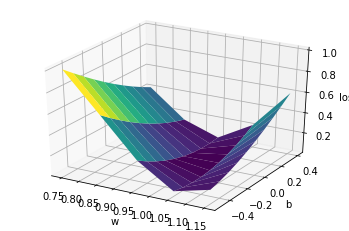

In [306]:
w = np.arange(0.75,1.25, 0.1)
b = np.arange(-0.5,0.5,0.1) 
W,B = np.meshgrid(w, b) 
Ls = np.array([TotalLoss2(Xtrain,Ytrain,w,b) for w,b in zip(np.ravel(W), np.ravel(B))]) 
print(np.min(Ls)) 
L = Ls.reshape(W.shape) 
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d') 
ax.plot_surface(W, B, L,rstride=1, cstride=1, cmap='viridis', edgecolor='none') 
ax.set_xlabel('w') 
ax.set_ylabel('b') 
ax.set_zlabel('loss') 
plt.show() 


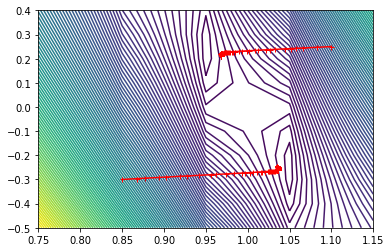

In [310]:
fig, ax = plt.subplots() 
federated_avg = mline.Line2D(global_weights[:,0], global_weights[:,1], color='red', marker='+', markersize=5)
federated_avg1 = mline.Line2D(global_weights1[:,0], global_weights1[:,1], color='red', marker='+', markersize=5)
ax.contour(W,B,L,100) 
ax.add_line(federated_avg)
ax.add_line(federated_avg1)
transform = ax.transAxes 
plt.show()